# Import Dependencies

In [1]:
!pip install split-folders

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import cv2
import shutil
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import splitfolders
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

In [3]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
!nvcc --version

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0


# Load Dataset

Dataset : https://www.kaggle.com/datasets/lexset/synthetic-asl-alphabet/data

In [5]:
# Define path
TRAIN_PATH = "/kaggle/input/synthetic-asl-alphabet/Train_Alphabet"
TEST_PATH = "/kaggle/input/synthetic-asl-alphabet/Test_Alphabet"
DATASET_PATH = "datasets/synthetic-asl_alphabet"

# Split
splitfolders.ratio(
    TRAIN_PATH, 
    output= DATASET_PATH,
    seed = 100, 
    ratio = (.8, .2), 
    group_prefix = None, 
    move = False
)

# Define directory
TRAIN_DIR = 'datasets/synthetic-asl_alphabet/train'
VAL_DIR = 'datasets/synthetic-asl_alphabet/val'
TEST_DIR  = 'datasets/synthetic-asl_alphabet/test'

# Ensure the test directory exists
os.makedirs(TEST_DIR, exist_ok=True)

# Copy/move test data to the test directory
for category in os.listdir(TEST_PATH):
    category_path = os.path.join(TEST_PATH, category)
    if os.path.isdir(category_path):
        shutil.copytree(category_path, os.path.join(TEST_DIR, category))

Copying files: 24300 files [03:50, 105.37 files/s]


In [6]:
# Datagen
train_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    height_shift_range = 0.2, 
    width_shift_range = 0.2,
    zoom_range = 0.2,
    shear_range = 0.2,  
    horizontal_flip = True,
    fill_mode ='nearest'
)
val_test_datagen = ImageDataGenerator(
    rescale=1. / 255
)

# Setup
BATCH_SIZE = 32
IMG_SIZE = (150, 150)

# Generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    color_mode = 'rgb',
    class_mode='sparse',
    shuffle = True
)
val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    batch_size = BATCH_SIZE,
    target_size = IMG_SIZE,
    color_mode = 'rgb',
    class_mode ='sparse',
    shuffle = False
)
test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size = BATCH_SIZE,
    target_size = IMG_SIZE,
    color_mode = 'rgb',
    class_mode ='sparse',
    shuffle = False
)

Found 19440 images belonging to 27 classes.
Found 4860 images belonging to 27 classes.
Found 2700 images belonging to 27 classes.


In [7]:
# Setup
class_mapping = train_generator.class_indices
total_classes = len(class_mapping)
class_names = list(class_mapping.keys())

print(class_mapping)
print(total_classes)
print(class_names)

{'A': 0, 'B': 1, 'Blank': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}
27
['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


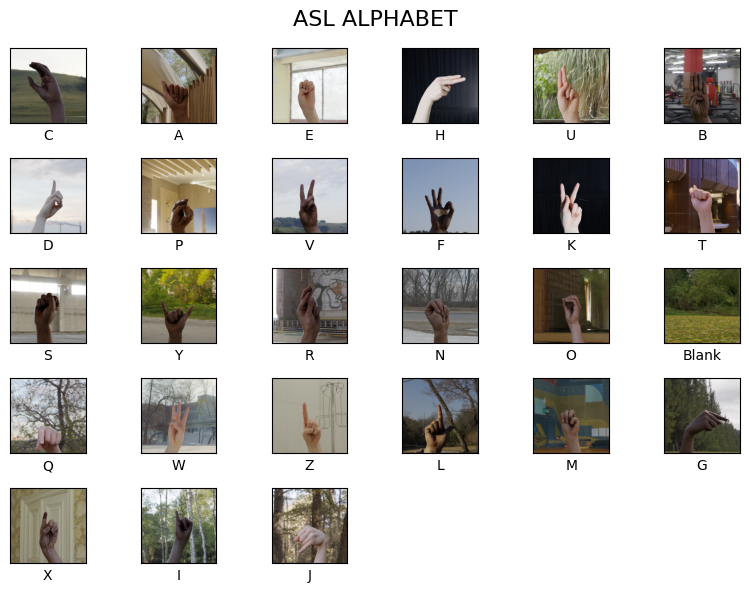

In [8]:
# Plot Setup
num_rows = 5
num_cols = (total_classes // num_rows) + (total_classes % num_rows > 0) 

# Define Plot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 6))
fig.suptitle('ASL ALPHABET', fontsize=16)

# Directory Loop
for i, class_dir in zip(range(total_classes), os.listdir(TRAIN_DIR)):
    row = i // num_cols
    col = i % num_cols
    class_path = os.path.join(TRAIN_DIR, class_dir)
    for file in os.listdir(class_path):
        if file.endswith(".png"):  
            image_path = os.path.join(class_path, file)
            img = plt.imread(image_path)
            axes[row, col].imshow(img)
            axes[row, col].set_xticks([])
            axes[row, col].set_yticks([])
            axes[row, col].set_xlabel(class_dir, fontsize=10)
            break  
            
# Remove unused subplot
for i in range(total_classes, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

# Model

In [13]:
tf.keras.backend.clear_session()

In [14]:
base_model = tf.keras.applications.EfficientNetV2B1(
    include_top = False,
    weights = 'imagenet',
    input_shape = IMG_SIZE + (3,),
    classes = total_classes
)

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(total_classes, activation='softmax', name = 'output_layer')], 
    name="Synthentic_ASL_Alphabet_Model"
)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model.summary()

Model: "Synthentic_ASL_Alphabet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b1 (Functional)  │ ?                      │     6,931,124 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,931,124 (26.44 MB)

 Trainable params: 6,860,052 (26.17 MB)

 Non-trainable params: 71,072 (277.62 KB)

In [15]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(CustomCallback, self).__init__()
        self.best_val_acc = -float('inf')
        self.best_weights_acc = None

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
  
        if val_acc is not None and val_acc >= 0.95:
            print("\nValidation accuracy reached 95%. Stopping training.")
            self.model.stop_training = True
        elif val_acc is not None and val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            self.best_weights_acc = self.model.get_weights()
            print(f"\nValidation accuracy improved to {val_acc}. Saving weights.")
    
    def on_train_end(self, logs=None):
        if self.best_weights_acc is not None:
            self.model.set_weights(self.best_weights_acc)
            print("Model weights set to the best weights with validation accuracy: "
                  f"{self.best_val_acc:.4f}")

# Callbacks
custom_callback = CustomCallback()
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

callbacks = [custom_callback, reduce_lr]

In [16]:
history = model.fit(
    train_generator,
    epochs = 100,
    validation_data = val_generator,
    callbacks = callbacks
)

Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.0477 - loss: 3.4262
Validation accuracy improved to 0.03703703731298447. Saving weights.
608/608 ━━━━━━━━━━━━━━━━━━━━ 520s 651ms/step - accuracy: 0.0477 - loss: 3.4259 - val_accuracy: 0.0370 - val_loss: 12.4371 - learning_rate: 0.0010
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 314s 511ms/step - accuracy: 0.1246 - loss: 2.8930 - val_accuracy: 0.0370 - val_loss: 9.0515 - learning_rate: 0.0010
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.1004 - loss: 3.0401
Validation accuracy improved to 0.04259259253740311. Saving weights.
608/608 ━━━━━━━━━━━━━━━━━━━━ 313s 510ms/step - accuracy: 0.1004 - loss: 3.0400 - val_accuracy: 0.0426 - val_loss: 15.0469 - learning_rate: 0.0010
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.1857 - loss: 2.4782
Validation accuracy improved to 0.058847736567258835. Saving weights.
608/608 ━━━━━━━━━━━━━━━━━━━━ 313s 510ms/step - accuracy: 0.1857 - loss: 2.47

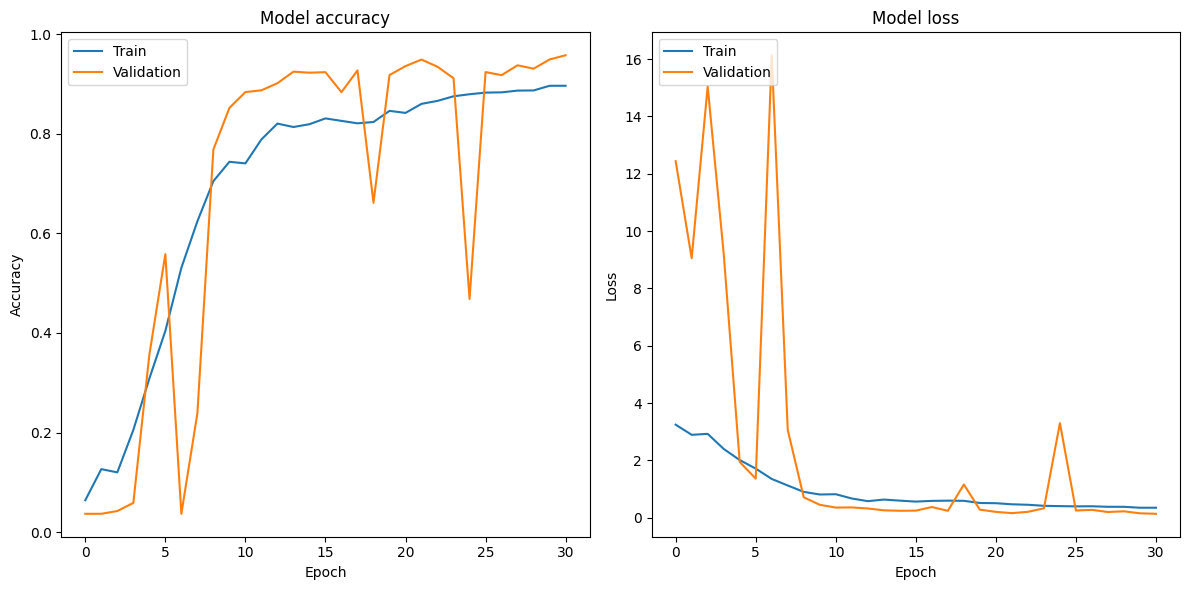

In [17]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Prediction

In [18]:
scores = model.evaluate(test_generator) 
print('Test loss: ', scores[0])
print('Test accuracy: ', scores[1])

85/85 ━━━━━━━━━━━━━━━━━━━━ 32s 372ms/step - accuracy: 0.9353 - loss: 0.2094
Test loss:  0.1439039707183838
Test accuracy:  0.9529629349708557


In [19]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print(report)

85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 381ms/step
              precision    recall  f1-score   support

           A       1.00      0.74      0.85       100
           B       0.99      0.99      0.99       100
       Blank       1.00      0.99      0.99       100
           C       0.99      0.97      0.98       100
           D       0.99      0.95      0.97       100
           E       0.96      0.97      0.97       100
           F       0.92      1.00      0.96       100
           G       0.98      0.98      0.98       100
           H       0.99      0.99      0.99       100
           I       0.94      0.98      0.96       100
           J       0.99      0.97      0.98       100
           K       0.99      0.99      0.99       100
           L       0.98      0.99      0.99       100
           M       0.61      0.96      0.74       100
           N       0.97      0.68      0.80       100
           O       0.94      0.98      0.96       100
           P       0.98      1.00      

# Deploy

In [20]:
model.save("synthetic_asl_alphabet_effnetv2b1.h5")